# Taller 2: Camilo Fernandez

In [1]:
%reset -sf

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy
import networkx as nx


### Clases Requeridas

In [3]:
class Vertice: #Clase que representa un punto en el plano, guardando su coordenada x, y, 
               #y una lista de aristas incidentes; además, guarda el tipo de punto y cuál es su color
    def __init__(self, tag, x=None, y=None, incidente=[], tipo='n/a'):
        self.tag = tag
        self.x = x
        self.y = y
        self.incidente = incidente
        self.tipo = tipo
        self.color = None

    def __repr__(self):
        return f'{self.tag}<{self.tipo}>({self.x}, {self.y}, {[i.label for i in self.incidente]})'

    def toTuple(self):
        return (self.x, self.y)

    def __lt__(self, p):
        return (self.y > p.y) or (self.y == p.y and self.x < p.x)


class Arista: #Clase que representa una arista en el plano, guardando sus puntos de inicio y fin
    def __init__(self, inicio, final):
        self.inicio = inicio
        self.final = final

    def __repr__(self):
        return f'Edge({self.inicio}, {self.final})'

    def add2plot(self):
        plt.plot([self.inicio.x, self.final.x], [self.inicio.y, self.final.y], '-')


class SemiArista: #Clase que representa una semi-arista en el plano, guardando su punto de inicio, 
                  #y su siguiente semi-arista, su anterior semi-arista, su semi-arista hermana y su cara
    def __init__(self, label=None, punto_inicio=None, prev=None, next=None, twin=None, cara=None):
        self.tag = label
        self.punto_inicio = punto_inicio
        self.prev = prev
        self.next = next
        self.twin = twin
        self.cara = cara
        self.helper = None

    def __repr__(self):
        if self.next:
            return f'{self.tag}({self.punto_inicio}, {self.next.punto_inicio})'
        else:
            return f'{self.tag}({self.punto_inicio})'

    def add2plot(self, color='-c'):  #Funcion que plotea la semi-arista en el plano
        plt.plot([self.punto_inicio.x, self.next.punto_inicio.x], [self.punto_inicio.y, self.next.punto_inicio.y], color,
                 label=self.tag)

    def interseccion_con_ln(self, y): #Funcion que calcula la interseccion de la semi-arista con la linea de barrido
        alpha = (y - self.next.punto_inicio.y) / (self.punto_inicio.y - self.next.punto_inicio.y)
        x = alpha * self.punto_inicio.x + (1 - alpha) * self.next.punto_inicio.x
        return x


class Cara: #Clase que representa una cara en el plano, guardando su frontera exterior y su frontera interior
    def __init__(self, frontera_ext=[], frontera_inn=[], tag=None):
        self.frontera_ext = frontera_ext
        self.frontera_inn = frontera_inn
        self.tag = tag
        self.color = None

    def __repr__(self):
        return f'Face(inn: {self.frontera_inn}, ext: {self.frontera_ext})'


### Funciones Auxiliares

In [4]:
def crearNodos(N): #Funcion que crea los nodos de la lista N (lista de tuplas)
    return [Vertice(f'V{N.index(i)}', i[0], i[1]) for i in N]

def d(p0, p1, p2):  #Funcion que calcula el determinante de 3 puntos
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2

    return ((x1 - x0) * (y2 - y0) - (x2 - x0) * (y1 - y0))


def obtenerDirecciondeRotacion(p0, p1, p2): #Funcion que calcula la direccion de rotacion de 3 puntos
    d_result = d(p0, p1, p2)
    if d_result > 0:
        return 'l'
    elif d_result == 0:
        return 'noRotation'
    else:
        return 'r'

def obtenerTiposNodos(SE): #Funcion que obtiene los tipos de los nodos de la lista de semiaristas SE
    for se in SE:
        prev_point = se.prev.punto_inicio.toTuple()
        curr_point = se.punto_inicio.toTuple()
        next_point = se.next.punto_inicio.toTuple()
        if (se.punto_inicio.y >= se.prev.punto_inicio.y and se.punto_inicio.y > se.next.punto_inicio.y) or (
                se.punto_inicio.y > se.prev.punto_inicio.y and se.punto_inicio.y >= se.next.punto_inicio.y):
            if obtenerDirecciondeRotacion(prev_point, curr_point, next_point) == 'l':
                se.punto_inicio.tipo = 's'  #divide
            else:
                se.punto_inicio.tipo = 'o'  #origen
        elif (se.punto_inicio.y <= se.prev.punto_inicio.y and se.punto_inicio.y < se.next.punto_inicio.y) or (
                se.punto_inicio.y < se.prev.punto_inicio.y and se.punto_inicio.y <= se.next.punto_inicio.y):
            if obtenerDirecciondeRotacion(prev_point, curr_point, next_point) == 'l':
                se.punto_inicio.tipo = 'm'  #union
            else:
                se.punto_inicio.tipo = 'e'  #final
        else: 
            se.punto_inicio.tipo = 'r'  #regular
    return

def obtenerAristasDobleConectadas(N):
    #crea los nodos de la lista N (lista de tuplas)
    Nodos = crearNodos(N)

    #crea las aristas de la lista N (lista de tuplas)
    E = [Arista(Nodos[i], Nodos[(i + 1) % len(Nodos)]) for i in range(len(Nodos))]

    #crea las semiaristas de la lista E (lista de aristas)
    SE = [[], []]

    for i in range(len(E)):
        new_semi = SemiArista(punto_inicio=E[i].inicio, label=f'S{i},{1}')
        new_twin = SemiArista(punto_inicio=E[i].final, label=f'S{i},{2}')
        new_semi.twin = new_twin
        new_twin.twin = new_semi
        SE[0].append(new_semi)
        SE[1].append(new_twin)

    SE[1].reverse()

    #Añade next y prev a las semiaristas de la cara interior
    for i in range(len(SE[0]) - 1):
        SE[0][i].next = SE[0][i + 1]
    SE[0][-1].next = SE[0][0]

    
    for i in range(len(SE[0]) - 1):
        SE[0][i].prev = SE[0][i - 1]
    SE[0][-1].prev = SE[0][-2]

    #Añade next y prev a las semiaristas de la cara exterior
    for i in range(len(SE[1]) - 1):
        SE[1][i].next = SE[1][i + 1]
    SE[1][-1].next = SE[1][0]

   
    for i in range(len(SE[1]) - 1):
        SE[1][i].prev = SE[1][i - 1]
    SE[1][-1].prev = SE[1][-2]
    

    for i in range(len(Nodos)):
        Nodos[i].incidente = [SE[0][i], SE[0][i].twin.next]

    #Inicializa las variables para obtener las fronteras de la poli
    next = SE[0][1]
    v0 = SE[0][0].punto_inicio
    count = 0

    #Itera sobre la lista de semiaristas para encontrar un ciclo (Frontera)
    frontier_1 = [SE[0][0]]

    while next.punto_inicio != v0:
        if count > len(SE[0]): break
        count += 1
        frontier_1.append(next)
        next = next.next

    #Inicializa las variables para obtener las fronteras de la poli
    next = SE[1][1]
    v0 = SE[1][0].punto_inicio
    count = 0

    #Itera sobre la lista de semiaristas para encontrar un ciclo (Frontera)
    frontier_2 = [SE[1][0]]

    while next.punto_inicio != v0:
        if count > len(SE[1]): break
        count += 1
        frontier_2.append(next)
        next = next.next

    #Crea dos caras con las fronteras encontradas
    f1 = Cara(frontera_inn=frontier_1, frontera_ext=None, tag='F1')  #Ext Face
    f2 = Cara(frontera_inn=None, frontera_ext=frontier_2, tag='F2')  #Inn Face

    #Añade las caras a las semiaristas
    for se in f1.frontera_inn:
        se.cara = f1
    for se in f2.frontera_ext:
        se.cara = f2

    #Crea una lista de caras
    face_list = [f1, f2]

    return face_list, Nodos, SE[0] + SE[1], E #Retorna las caras, los nodos, las semiaristas y las aristas

### Clase Nodo y sus Funciones de Arbol Binario

In [5]:
class Node: #clase nodo de arbol binario
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

def insertBST(root, node, y): #inserta un nodo en el arbol binario

    if (node.data.interseccion_con_ln(y) < root.data.interseccion_con_ln(y)):
        if root.left is None:
            root.left = node
        else:
            insertBST(root.left, node, y)
    else:
        if root.right is None:
            root.right = node
        else:
            insertBST(root.right, node, y)


def inOrder(node): #recorre el arbol binario en orden y lo guarda en un arreglo
    inorderArr = []

    if node.left is not None:
        leftInorderArr = inOrder(node.left)
        inorderArr.extend(leftInorderArr)

    inorderArr.append(node.data)

    if node.right is not None:
        rightInorderArr = inOrder(node.right)
        inorderArr.extend(rightInorderArr)
    return inorderArr


def printTArr(TArr): #imprime el arreglo de aristas
    print(f"TArr : {[se.label for se in TArr]}")

### Funciones de Dataframes

In [6]:
def nodesToDf(nodos): #crea un dataframe con los nodos
    tipos = [n.tipo for n in nodos]
    coords = [n.toTuple() for n in nodos]
    tags = [n.tag for n in nodos]
    incidentes = [[i.tag for i in n.incidente] for n in nodos]
    colores = [n.color for n in nodos]
    d = {'Nodo': tags, 'Tipo': tipos, 'Coords': coords, 'Incidentes': incidentes, 'Colores': colores}
    return pd.DataFrame(data=d)


def facesToDf(caras): #crea un dataframe con las caras
    fronteras_inn = [[s.tag for s in f.frontera_inn] if f.frontera_inn != None else None for f in caras]
    fronteras_ext = [[s.tag for s in f.frontera_ext] if f.frontera_ext != None else None for f in caras]
    colores = [f.color if f.color != None else None for f in caras]
    tags = [f.tag for f in caras]
    d = {'Cara': tags, 'Frontera inn': fronteras_inn, 'Frontera ext': fronteras_ext, 'Colores': colores}
    return pd.DataFrame(data=d)


def semiEdgesToDf(semiAristas): #crea un dataframe con las semiaristas
    tags = [se.tag for se in semiAristas]
    puntos_iniciales = [se.punto_inicio.tag for se in semiAristas]
    puntos_finales = [se.next.punto_inicio.tag for se in semiAristas]
    prevs = [se.prev.tag for se in semiAristas]
    nexts = [se.next.tag for se in semiAristas]
    twins = [se.twin.tag for se in semiAristas]
    faces = [se.cara.tag if se.cara != None else None for se in semiAristas]

    d = {'SemiAristas': tags, 'Puntos iniciales': puntos_iniciales, 'Puntos finales': puntos_finales, 'Prev': prevs, 'Nexts': nexts,
         'Twin': twins, 'Cara': faces}
    return pd.DataFrame(data=d)



### Funciones de Ploteo

In [7]:
def plotAristas(E, color='-c'):  #Plotea las aristas o las semiaristas
    for i in E:
        i.add2plot(color)


def plotTipoNodo(nodos): #Plotea los nodos segun su tipo
    puntos = {}
    tipos = {
        'n/a': 'o',
        'o': 'sg',  
        'e': 'sr',  
        's': '^k',
        'm': 'vy',
        'r': 'ob',
    }
    for nodo in nodos:
        t = tipos[nodo.tipo]
        if t not in puntos:
            puntos[t] = [nodo]
        else:
            puntos[t].append(nodo)

    for i in puntos:
        x = [j.x for j in puntos[i]]
        y = [j.y for j in puntos[i]]
        plt.plot(x, y, i, label=puntos[i][0].tipo)


def plotNodosTresColoreados(nodos): #Plotea los nodos segun su color despues de la tres coloreacion
    puntos = {}
    tipos = {
        'r': 'or',
        'g': 'og',  
        'b': 'ob',
        'None': 'ok'  
    }
    for nodo in nodos:
        t = tipos[nodo.color]
        if t not in puntos:
            puntos[t] = [nodo]
        else:
            puntos[t].append(nodo)

    for i in puntos:
        x = [j.x for j in puntos[i]]
        y = [j.y for j in puntos[i]]
        plt.plot(x, y, i, label=puntos[i][0].color)

def plotNodosTresCamaras(nodos, color): #Plotea los las camaras dando respuesta al problema de la galeria de arte
    puntos = {}
    tipos = {
        'r': 'or',
        'g': 'og',  
        'b': 'ob',
        'None': 'ok'  
    }
    for nodo in nodos:
        if nodo.color == color:
            t = tipos[nodo.color]
            if t not in puntos:
                puntos[t] = [nodo]
            else:
                puntos[t].append(nodo)

    for i in puntos:
        x = [j.x for j in puntos[i]]
        y = [j.y for j in puntos[i]]
        plt.plot(x, y, i, label=puntos[i][0].color)



def plotFronteraExt(caras, index, color='-c'): #Plotea la frontera exterior de una cara
    plotAristas(caras[index].frontera_ext, color)
    plt.xlim(0, 15)
    plt.ylim(-5, 15)

### Clase Galeria de Arte

In [8]:
class GaleriadeArte: #Clase que se encarga de hacer el grafo y-monotono, hacer la tringulación,
                     # crear el grafo dual y hacer tres coloreacion sobre los vertices del poligono
    def __init__(self, Aristas, SemiAristas, Nodos, Caras, color=['r', 'g', 'b']):
        self.Aristas = Aristas
        self.SemiAristas = SemiAristas
        self.Nodos = Nodos
        self.Caras = Caras

        self.Q = []
        self.T = None
        self.TArr = []

        self.coloreado = []
        self.vertices_coloreados = []
        self.nodos_grafo = []
        self.aristas_grafo = []
        self.grafo = []
        self.color = color

    def obtenerLado(self, p): #retorna si la arista tiene el poligono a la izquierda o a la derecha 
                              # usando la cara exterior
        for i in p.incidente:
            if i.cara.tag == "F1":
                ei = i
                break

        if ei.prev.punto_inicio.y < ei.next.punto_inicio.y:
            return "r"  # right
        return "l"  # left

    def obtenerLadoV2(self, p, f): #retorna si la arista tiene el poligono a la izquierda o a la derecha
                                   # usando la cara que se le pasa como parametro
        for i in p.incidente:
            if i.cara.tag == f.tag:
                ei = i
                break

        if ei.prev.punto_inicio.y > ei.next.punto_inicio.y:
            return "r"  # right
        return "l"  # left

    def eliminarSemiArista(self, se, y): #Elimina una semiarista del arbol T
        self.TArr = inOrder(self.T)

        if se in self.TArr:
            self.TArr.remove(se)
            root = self.TArr.pop(0)
            self.T = Node(root)
            for i in self.TArr:
                insertBST(self.T, Node(i), y - 0.2)
            self.TArr = inOrder(self.T)
        else:
            raise ValueError("Trying to delete a semiedge that is not in T")

    def add2T(self, e, p): #Agrega una semiarista al arbol T
        insertBST(self.T, Node(e), p.y - 0.2)
        self.TArr = inOrder(self.T)

    def obtenerCercanoIzquierda(self, p): #Obtiene la semiarista sobre T que es mas cercana a la izquierda del vertice p
        xs = [i.interseccion_con_ln(p.y) for i in self.TArr]

        xs.append(float(p.x))
        xs.sort()
        index = xs.index(float(p.x))

        ej = self.TArr[index - 1]  # el + cerca de vi por la izquierda

        return ej

    def hacerMonotono(self): #Funcion que hace un poligono y-monotono
        iteraciones = 0
        self.Q = deepcopy(self.Nodos)
        self.Q.sort()  
        for i in self.Q[0].incidente:
            if i.cara.tag == "F1":
                e1 = i
                break
        self.T = Node(e1)

        while len(self.Q) != 0:
            self.TArr = inOrder(self.T)
            p = self.Q.pop(0)

            self.manipulacionVertice(p)

            iteraciones += 1

    def manipulacionOrigen(self, p): #Funcion que se encarga de hacer la manipulacion de un vertice de origen

        for i in p.incidente:
            if i.cara.tag == "F1":
                ei = i.prev
                break

        self.add2T(ei, p)
        ei.helper = p

    def manipulacionFinal(self, p): #Funcion que se encarga de hacer la manipulacion de un vertice final
        for i in p.incidente:
            if i.cara.tag == "F1":
                ei_1 = i
                break

        if ei_1.helper.tipo == 'm':
            self.añadirDiagonal(p, ei_1.helper)
        self.eliminarSemiArista(ei_1, p.y)

    def manipulacionSep(self, p): #Funcion que se encarga de hacer la manipulacion de un vertice separador
        ej = self.obtenerCercanoIzquierda(p)
        self.añadirDiagonal(p, ej.helper)
        ej.helper = p

        for i in p.incidente:
            if i.cara.tag == "F1":
                ei = i.prev
        ei.helper = p
        self.add2T(ei, p)

    def manipulacionUnion(self, p): #Funcion que se encarga de hacer la manipulacion de un vertice de union
        for i in p.incidente:
            if i.cara.tag == "F1":
                ei_1 = i
                break

        if ei_1.helper.tipo == 'm':
            self.añadirDiagonal(p, ei_1.helper)

        self.eliminarSemiArista(ei_1, p.y)
        ej = self.obtenerCercanoIzquierda(p)
        if ej.helper.tipo == 'm':
            self.añadirDiagonal(p, ej.helper)

        ej.helper = p

    def manipulateRegular(self, p): #Funcion que se encarga de hacer la manipulacion de un vertice regular
        if self.obtenerLado(p) == 'r':  
            for i in p.incidente:
                if i.cara.tag == "F1":
                    ei_1 = i
                    break
            if ei_1.helper.tipo == "m":
                self.añadirDiagonal(p, ei_1.helper)
            self.eliminarSemiArista(ei_1, p.y)
            ei_1.prev.helper = p
            self.add2T(ei_1.prev, p)
        else:
            ej = self.obtenerCercanoIzquierda(p)
            if ej.helper.tipo == "m":
                self.añadirDiagonal(p, ej.helper)
            ej.helper = p

    def manipulacionVertice(self, p): #Funcion que se encarga de llamar a la funcion correspondiente a la manipulacion de un vertice
        tipo = p.tipo
        if tipo == 'o':
            self.manipulacionOrigen(p)

        elif tipo == 'e':
            self.manipulacionFinal(p)

        elif tipo == 's':
            self.manipulacionSep(p)

        elif tipo == 'm':
            self.manipulacionUnion(p)

        elif tipo == 'r':
            self.manipulateRegular(p)

        else:
            print("no se profe, me deprimi")

    def añadirDiagonal(self, v1, v2): #Funcion que añade una diagonal al poligono y a la lista de aristas doble conectadas
        ek1 = SemiArista(punto_inicio=v1)
        ek2 = SemiArista(punto_inicio=v2)
        ek1.twin = ek2
        ek2.twin = ek1

        v1.incidente.append(ek1)
        v2.incidente.append(ek2)

        for i in self.SemiAristas:
            if (i.punto_inicio.toTuple() == v1.toTuple() and i.cara.frontera_inn == None):
                ea = i
                eb = None
                for j in self.SemiAristas:
                    if j != i:
                        if (j.punto_inicio.toTuple() == v2.toTuple() and j.cara.frontera_inn == None and i.cara.tag == j.cara.tag):
                            eb = j
                            break
                if eb is not None:
                    break


        ea.prev.next = ek1
        eb.prev.next = ek2
        ek1.prev = ea.prev
        ek2.prev = eb.prev
        ek1.next = eb
        ek2.next = ea
        ea.prev = ek2
        eb.prev = ek1

        self.Caras.remove(ea.cara)

        k = int(len(self.SemiAristas) / 2)
        ek1.tag = f"S{k},1"
        ek2.tag = f"S{k},2"

        #Inicializa variables para obtener fronteras de la cara
        next = ek1.next
        v0 = ek1.punto_inicio

        #Itera sobre la SE para encontrar un ciclo (Frontera)
        frontier_1 = [ek1]

        while next.punto_inicio.toTuple() != v0.toTuple():
            frontier_1.append(next)
            next = next.next

        #Inicializa variables para obtener fronteras de la cara
        next = ek2.next
        v0 = ek2.punto_inicio

        #Itera sobre la SE para encontrar un ciclo (Frontera)
        frontier_2 = [ek2]

        while next.punto_inicio.toTuple() != v0.toTuple():
            frontier_2.append(next)
            next = next.next

        self.SemiAristas.append(ek1)
        self.SemiAristas.append(ek2)

        k = np.random.randint(100, 2**9)

        Fa = Cara(frontera_ext=frontier_1, frontera_inn=None, tag=f"F{k}")
        Fb = Cara(frontera_ext=frontier_2, frontera_inn=None, tag=f"F{k + 1}")

        for i in frontier_1:
            i.cara = Fa

        for i in frontier_2:
            i.cara = Fb

        self.Caras.append(Fa)
        self.Caras.append(Fb)
        
        for i in range(1, len(self.Caras)):
            self.Caras[i].tag = f"F{i + 1}"

    def triangularCara(self, f): #Funcion que se encarga de triangular una cara
        S_Q = [se.punto_inicio for se in f.frontera_ext]
        S_Q.sort()

        S = [S_Q[0], S_Q[1]]

        for i in range(2, len(S_Q) - 1):  
            if self.obtenerLadoV2(S[-1], f) != self.obtenerLadoV2(S_Q[i], f):
                s_len = len(S)
                while len(S) > 1:
                    s = S.pop()
                    self.checkDiagonalOS(S_Q[i], s, f)

                S.append(S_Q[i - 1])
                S.append(S_Q[i])
            else:
                s = S.pop()
                s_len = len(S)
                for j in range(0, s_len):

                    if len(S) == 1:
                        a = self.checkDiagonalSS(S_Q[i], s, S[0], f)
                        if not a:
                            S.append(s)
                        break
                    s = S.pop()
                    a = self.checkDiagonalSS(S_Q[i], S[j - 1], s, f)
                    if not a:
                        S.append(s)
                        break

                S.append(S_Q[i])
        
        #for s in S:
        #    self.checkDiagonalOS(S_Q[-1], s,f)
        #self.addDiagonal(S_Q[-1], s)

    def triangular(self): #Funcion que se encarga de triangular el poligono
        lf = deepcopy(self.Caras)
        for f in lf:
            if f.tag != "F1":
                self.triangularCara(f)

    def checkDiagonalOS(self, a, b, f): #Funcion que se encarga de verificar si se puede añadir una diagonal 
                                        #entre dos vertices que estan en lados opuestos del poligono
        bo = 1
        for i in a.incidente:
            if ((i.prev.punto_inicio == b) or (i.next.punto_inicio == b)) and (i.cara == f):
                bo = 0
                break
        if bo:
            self.añadirDiagonal(a, b)

    def checkDiagonalSS(self, a, b, c, f): #Funcion que se encarga de verificar si se puede añadir una diagonal
                                            #entre dos vertices que estan en el mismo lado del poligono
        bo = 1
        for i in a.incidente:
            if ((i.prev.punto_inicio == c) or (i.next.punto_inicio == c)) and (i.cara == f):
                bo = 0
                break
        if bo:
            if self.obtenerLadoV2(a, f) == "r":
                if obtenerDirecciondeRotacion(a.toTuple(), b.toTuple(), c.toTuple()) == "r":
                    self.añadirDiagonal(a,c)
                    return True
            elif self.obtenerLadoV2(a, f) == "l":
                if obtenerDirecciondeRotacion(a.toTuple(), b.toTuple(), c.toTuple()) == "l":
                    self.añadirDiagonal(a,c)
                    return True
        return False
    
    def colorFace(self,node): #colorFace es una funcion que se encarga de colorear los vertices de una cara
        color = self.color
        for i in self.Caras[1:]:
            if i.tag == node:
                cara = i
                break

        areNone = []
        notNone = []
        for i in cara.frontera_ext:
            if i.punto_inicio.toTuple() in [j.toTuple() for j in self.vertices_coloreados]:
                i.punto_inicio.color = [j.color for j in self.vertices_coloreados if j.toTuple() == i.punto_inicio.toTuple()][0]
            if i.punto_inicio.color is not None:
                notNone.append(i.punto_inicio)
            else:
                areNone.append(i.punto_inicio)

        if len(areNone) == 3:
            for i in range(3):
                areNone[i].color = color[i]
                for v in self.Nodos:
                    if v.toTuple() == areNone[i].toTuple():
                        v.color = color[i]
                        self.vertices_coloreados.append(v)

        elif len(areNone) == 1:
            scolor = [k for k in color if k not in [j.color for j in notNone]][0]
            areNone[0].color = scolor
            for v in self.Nodos:
                if v.toTuple() == areNone[0].toTuple():
                    v.color = scolor
                    self.vertices_coloreados.append(v)
        else:
            print("No se profe me deprimi :(")




    def threeColor(self,node): #threeColor es una funcion que se encarga de colorear las caras de un poligono
        self.coloreado.append(node)
        self.colorFace(node)
        # get the neighbors of the node
        neighbors = self.grafo.neighbors(node)
        for n in neighbors:
            if n not in self.coloreado:
                self.threeColor(n)

    def artGalleryProblem(self): #artGalleryProblem es una funcion que se encarga de resolver el problema de la galeria de arte
                                 #helper de threeColor         
        node = list(self.grafo.nodes)[0]
        self.threeColor(node)


    def dualGraph(self): #dualGraph es una funcion que se encarga de crear el grafo dual del poligono   
        self.nodos_grafo = [f.tag for f in self.Caras[1:]]
        self.aristas_grafo = []

        for f in self.Caras[1:]:
            for i in f.frontera_ext:
                for j in self.Caras[1:]:
                    if f != j and i.twin in j.frontera_ext:
                        if (j.tag, f.tag) not in self.aristas_grafo:
                            self.aristas_grafo.append((f.tag, j.tag))
        self.grafo = nx.Graph()
        self.grafo.add_nodes_from(self.nodos_grafo)
        self.grafo.add_edges_from(self.aristas_grafo)
        


    def draw_graph(self): #draw_graph es una funcion que se encarga de dibujar el grafo dual del poligono
        nx.draw(self.grafo, with_labels=True)

    def menos_repetido(self):
        contador = {}

        
        for i in self.Nodos:
            if i.color in contador:
                contador[i.color] += 1
            else:
                contador[i.color] = 1

        
        color_rep = None
        numero_rep = float('inf')
        for value, count in contador.items():
            if count < numero_rep:
                color_rep = value
                numero_rep = count
        print("El color menos repetido es: ", color_rep, " y se repite ", numero_rep, " veces")        
        return (color_rep, numero_rep)
        

# Punto 1 
### Listas de Aristas Doble Conectadas y Plot


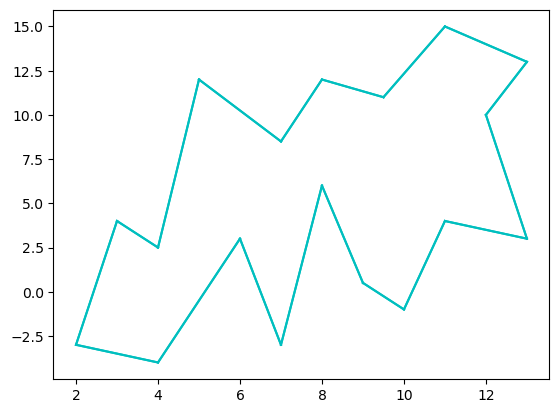

In [9]:
N = [(9, 0.5), (8, 6), (7, -3), (6, 3), (4, -4), (2, -3), (3, 4), (4, 2.5), (5, 12), (7, 8.5), (8, 12), (9.5, 11),
     (11, 15), (13, 13), (12, 10), (13, 3), (11, 4), (10, -1)]
caras, nodos, semiEdges, Aristas = obtenerAristasDobleConectadas(N)
plotAristas(semiEdges)
plt.show()

In [10]:
dfnodos = nodesToDf(nodos)
dfsemiaristas = semiEdgesToDf(semiEdges)
dfcaras = facesToDf(caras)

In [11]:
display(dfnodos)
display(dfsemiaristas)
display(dfcaras)

,Nodo,Tipo,Coords,Incidentes,Colores
0,V0,n/a,"(9, 0.5)","[S0,1, S17,2]",None
1,V1,n/a,"(8, 6)","[S1,1, S0,2]",None
2,V2,n/a,"(7, -3)","[S2,1, S1,2]",None
3,V3,n/a,"(6, 3)","[S3,1, S2,2]",None
4,V4,n/a,"(4, -4)","[S4,1, S3,2]",None
5,V5,n/a,"(2, -3)","[S5,1, S4,2]",None
6,V6,n/a,"(3, 4)","[S6,1, S5,2]",None
7,V7,n/a,"(4, 2.5)","[S7,1, S6,2]",None
8,V8,n/a,"(5, 12)","[S8,1, S7,2]",None
9,V9,n/a,"(7, 8.5)","[S9,1, S8,2]",None


,SemiAristas,Puntos iniciales,Puntos finales,Prev,Nexts,Twin,Cara
0,"S0,1",V0,V1,"S17,1","S1,1","S0,2",F1
1,"S1,1",V1,V2,"S0,1","S2,1","S1,2",F1
2,"S2,1",V2,V3,"S1,1","S3,1","S2,2",F1
3,"S3,1",V3,V4,"S2,1","S4,1","S3,2",F1
4,"S4,1",V4,V5,"S3,1","S5,1","S4,2",F1
5,"S5,1",V5,V6,"S4,1","S6,1","S5,2",F1
6,"S6,1",V6,V7,"S5,1","S7,1","S6,2",F1
7,"S7,1",V7,V8,"S6,1","S8,1","S7,2",F1
8,"S8,1",V8,V9,"S7,1","S9,1","S8,2",F1
9,"S9,1",V9,V10,"S8,1","S10,1","S9,2",F1


,Cara,Frontera inn,Frontera ext,Colores
0,F1,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,...",None,None
1,F2,None,"[S17,2, S16,2, S15,2, S14,2, S13,2, S12,2, S11...",None


# Punto 2

### Clasificacion de vertices

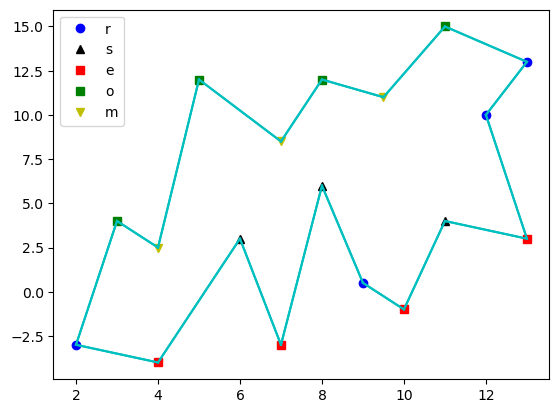

In [12]:
cicle = caras[0].frontera_inn
obtenerTiposNodos(cicle)
plotTipoNodo(nodos)
plt.legend()
plotAristas(semiEdges)
plt.show()

### Division del poligono en poligonos y-monotonos  

In [13]:
M = GaleriadeArte(Caras=caras, Nodos=nodos, SemiAristas=semiEdges, Aristas=Aristas)
M.hacerMonotono()

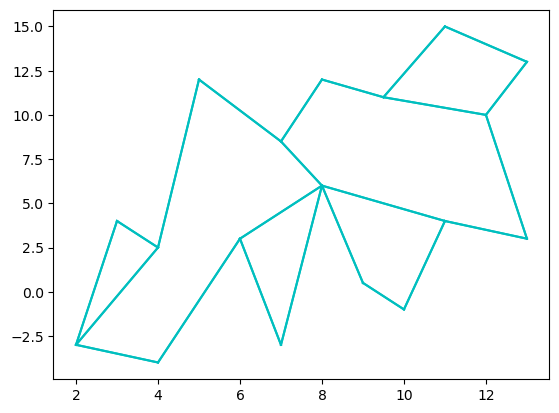

In [14]:
plotAristas(semiEdges)

plt.show()

In [15]:
dfnodos = nodesToDf(nodos)
dfsemiaristas = semiEdgesToDf(semiEdges)
dfcaras = facesToDf(caras)

In [16]:
display(dfnodos)
display(dfsemiaristas)
display(dfcaras)

,Nodo,Tipo,Coords,Incidentes,Colores
0,V0,r,"(9, 0.5)","[S0,1, S17,2]",None
1,V1,s,"(8, 6)","[S1,1, S0,2]",None
2,V2,e,"(7, -3)","[S2,1, S1,2]",None
3,V3,s,"(6, 3)","[S3,1, S2,2]",None
4,V4,e,"(4, -4)","[S4,1, S3,2]",None
5,V5,r,"(2, -3)","[S5,1, S4,2]",None
6,V6,o,"(3, 4)","[S6,1, S5,2]",None
7,V7,m,"(4, 2.5)","[S7,1, S6,2]",None
8,V8,o,"(5, 12)","[S8,1, S7,2]",None
9,V9,m,"(7, 8.5)","[S9,1, S8,2]",None


,SemiAristas,Puntos iniciales,Puntos finales,Prev,Nexts,Twin,Cara
0,"S0,1",V0,V1,"S17,1","S1,1","S0,2",F1
1,"S1,1",V1,V2,"S0,1","S2,1","S1,2",F1
2,"S2,1",V2,V3,"S1,1","S3,1","S2,2",F1
3,"S3,1",V3,V4,"S2,1","S4,1","S3,2",F1
4,"S4,1",V4,V5,"S3,1","S5,1","S4,2",F1
5,"S5,1",V5,V6,"S4,1","S6,1","S5,2",F1
6,"S6,1",V6,V7,"S5,1","S7,1","S6,2",F1
7,"S7,1",V7,V8,"S6,1","S8,1","S7,2",F1
8,"S8,1",V8,V9,"S7,1","S9,1","S8,2",F1
9,"S9,1",V9,V10,"S8,1","S10,1","S9,2",F1


,Cara,Frontera inn,Frontera ext,Colores
0,F1,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,...",None,None
1,F2,None,"[S18,2, S13,2, S12,2, S11,2]",None
2,F3,None,"[S20,1, S0,2, S17,2, S16,2]",None
3,F4,None,"[S20,2, S15,2, S14,2, S18,1, S10,2, S9,2, S19,2]",None
4,F5,None,"[S21,2, S2,2, S1,2]",None
5,F6,None,"[S22,1, S6,2, S5,2]",None
6,F7,None,"[S22,2, S4,2, S3,2, S21,1, S19,1, S8,2, S7,2]",None


# Punto 3

### Triangulacion

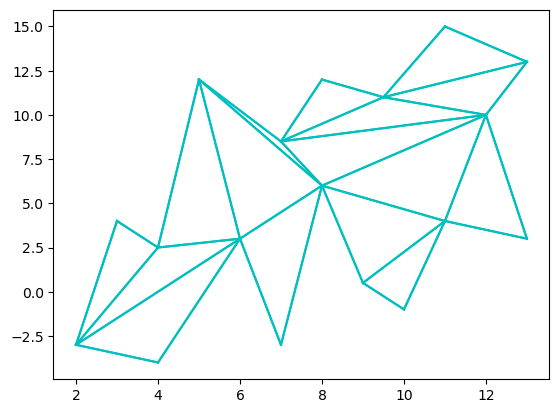

In [17]:
M.triangular()

plotAristas(semiEdges)
plt.show()

In [18]:
dfnodos = nodesToDf(nodos)
dfsemiaristas = semiEdgesToDf(semiEdges)
dfcaras = facesToDf(caras)

In [19]:
display(dfnodos)
display(dfsemiaristas)
display(dfcaras)

,Nodo,Tipo,Coords,Incidentes,Colores
0,V0,r,"(9, 0.5)","[S0,1, S17,2]",None
1,V1,s,"(8, 6)","[S1,1, S0,2]",None
2,V2,e,"(7, -3)","[S2,1, S1,2]",None
3,V3,s,"(6, 3)","[S3,1, S2,2]",None
4,V4,e,"(4, -4)","[S4,1, S3,2]",None
5,V5,r,"(2, -3)","[S5,1, S4,2]",None
6,V6,o,"(3, 4)","[S6,1, S5,2]",None
7,V7,m,"(4, 2.5)","[S7,1, S6,2]",None
8,V8,o,"(5, 12)","[S8,1, S7,2]",None
9,V9,m,"(7, 8.5)","[S9,1, S8,2]",None


,SemiAristas,Puntos iniciales,Puntos finales,Prev,Nexts,Twin,Cara
0,"S0,1",V0,V1,"S17,1","S1,1","S0,2",F1
1,"S1,1",V1,V2,"S0,1","S2,1","S1,2",F1
2,"S2,1",V2,V3,"S1,1","S3,1","S2,2",F1
3,"S3,1",V3,V4,"S2,1","S4,1","S3,2",F1
4,"S4,1",V4,V5,"S3,1","S5,1","S4,2",F1
...,...,...,...,...,...,...,...
61,"S30,2",V8,V3,"S29,1","S21,1","S30,1",F14
62,"S31,1",V7,V3,"S7,2","S30,1","S31,2",F15
63,"S31,2",V3,V7,"S32,1","S22,2","S31,1",F16
64,"S32,1",V5,V3,"S22,2","S31,2","S32,2",F16


,Cara,Frontera inn,Frontera ext,Colores
0,F1,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,...",None,None
1,F2,None,"[S21,2, S2,2, S1,2]",None
2,F3,None,"[S22,1, S6,2, S5,2]",None
3,F4,None,"[S23,1, S12,2, S11,2]",None
4,F5,None,"[S23,2, S18,2, S13,2]",None
5,F6,None,"[S24,1, S20,1, S0,2]",None
6,F7,None,"[S24,2, S17,2, S16,2]",None
7,F8,None,"[S26,1, S10,2, S9,2]",None
8,F9,None,"[S26,2, S25,1, S18,1]",None
9,F10,None,"[S27,1, S25,2, S19,2]",None


# Punto 4

### Creacion Grafo Dual

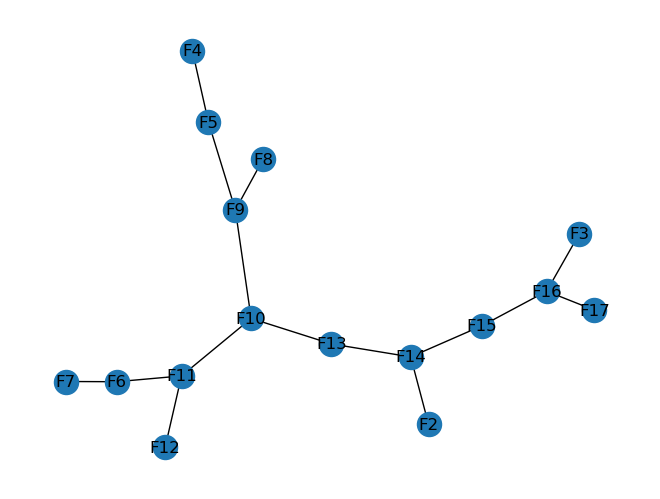

In [20]:
M.dualGraph()
M.draw_graph()

### Se hace la tres coloración de los nodos teniendo en cuenta el grafo dual

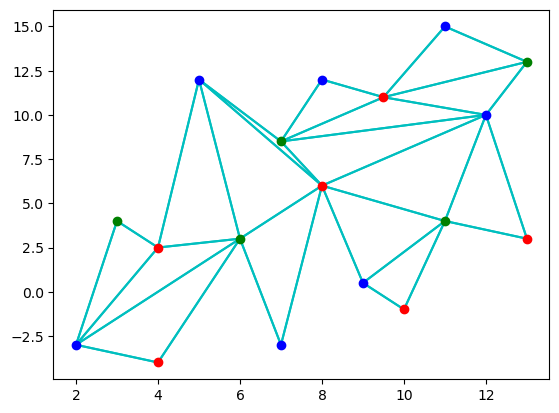

In [21]:
M.artGalleryProblem()
plotAristas(semiEdges)
plotNodosTresColoreados(nodos)
plt.show()

### Se busca el color que menos se repite, este representara los vertices donde se ubicaran las camaras

El color menos repetido es:  g  y se repite  5  veces


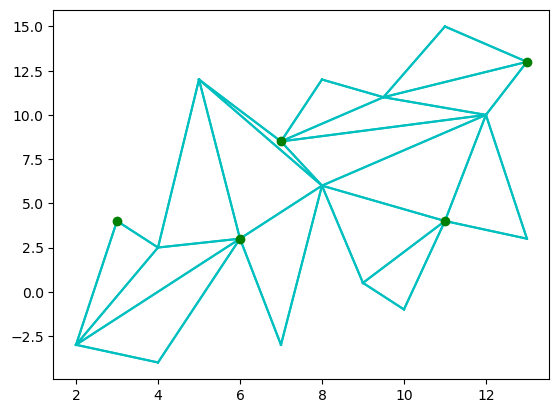

In [22]:
color = M.menos_repetido()
plotAristas(semiEdges)
plotNodosTresCamaras(nodos, color[0])
plt.show()

Así se concluye que se deben poner camaras en los 5 vertices de color verde.